<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day09_Imbalanced_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay
)

from sklearn.pipeline import Pipeline

plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
# Install imbalanced-learn
!pip install imbalanced-learn -q

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline


In [ ]:
# Load Telecom Churn dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

df = pd.read_csv(url)
print(f"Dataset loaded: {df.shape[0]} customers, {df.shape[1]} columns")
df.head()

Dataset loaded: 7043 customers, 21 columns


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
print(f"Target Variable: {df['Churn'].value_counts()}")
print(f"\nChurn Rate: {(df['Churn'] == 'Yes').mean():.1%}")

Target Variable: Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Rate: 26.5%


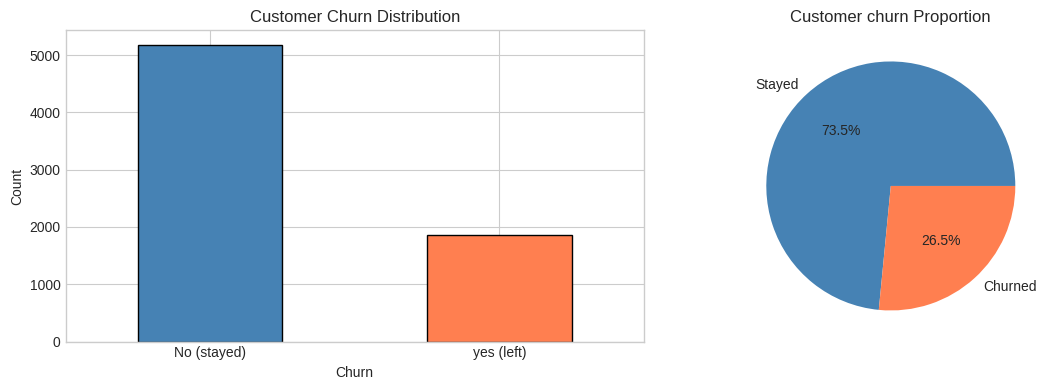

In [ ]:
#Visualizing the imbalance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

#Bar plot
df['Churn'].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'], edgecolor='black')
axes[0].set_title("Customer Churn Distribution")
axes[0].set_xlabel("Churn")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(['No (stayed)', "yes (left)"], rotation=0)

#Pie
df['Churn'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['steelblue', 'coral'],
                                labels=['Stayed', 'Churned'])
axes[1].set_title("Customer churn Proportion")
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
print("Columns Types: ")
print("="*40)
print(df.dtypes.value_counts())

print("\nMissing Values: ")
missing = df.isnull().sum()
if missing.sum() == 0:
  print(" None!")
else:
  print(missing[missing > 0])

Columns Types: 
object     18
int64       2
float64     1
Name: count, dtype: int64

Missing Values: 
 None!


Preparing the data

In [ ]:
df_clean = df.copy()

df_clean = df_clean.drop('customerID', axis=1)

df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'],
                                         errors='coerce')

#fill the missing values with 0
df_clean["TotalCharges"].fillna(0, inplace=True)

df_clean['Churn'] = (df_clean['Churn'] == 'Yes').astype(int)

print(f"Cleaned data: {df_clean.shape}")

Cleaned data: (7043, 20)


/tmp/ipython-input-2280716391.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean["TotalCharges"].fillna(0, inplace=True)


In [ ]:
#encode categorical variables
df_encoded = df_clean.copy()

cat_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
print(f"categorical columns: {cat_cols}")

df_encoded = pd.get_dummies(df_encoded, columns=cat_cols, drop_first=True)

print(f"Encoded data: {df_encoded.shape}")
df_encoded.head()

categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Encoded data: (7043, 31)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [ ]:
x = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

print(f"Features: {x.shape[0]}")
print(f"Target: {x.shape[1]}")
print(f"\nTarget distribution:")
print(f"     Class 0 (stayed): {(y==0).sum()}")
print(f"     Class 1 (churned): {(y==1).sum()}")

Features: 7043
Target: 30

Target distribution:
     Class 0 (stayed): 5174
     Class 1 (churned): 1869


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {x_train.shape[0]} samples")
print(f"\nTest set: {x_test.shape[0]} samples")

Training set: 5634 samples

Test set: 1409 samples


In [ ]:
# Scale features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

What's the problem with accuracy . . .

In [ ]:
y_pred_baseline = np.zeros(len(y_test))

accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"Accuracy: {accuracy_baseline:.1%}")

Accuracy: 73.5%


In [ ]:
#Lets look at other metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.1%}")
print(f"Precision: {precision_score(y_test, y_pred_baseline, zero_division=0):.1%}")
print(f"Recall: {recall_score(y_test, y_pred_baseline):.1%}")
print(f"F1 score: {f1_score(y_test, y_pred_baseline):.1%}")

#the recall is 0 so we catch zero churners

Accuracy: 73.5%
Precision: 0.0%
Recall: 0.0%
F1 score: 0.0%


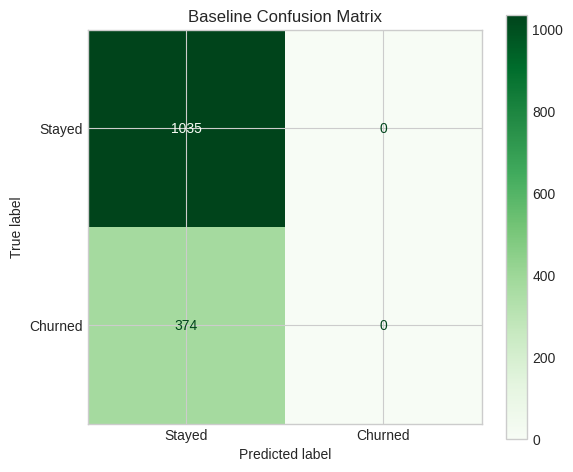

In [ ]:
#Confusion matrix for baseline
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_baseline,
                                        display_labels=['Stayed', 'Churned'], cmap='Greens', ax=ax)
ax.set_title("Baseline Confusion Matrix")
plt.tight_layout()

In [ ]:
#All predictions in the 'Stayed' column
#We miss ALL churners (bottom-left cell)

In [ ]:
"""
Baseline model

"""
model_baseline = LogisticRegression(random_state=42)
model_baseline.fit(x_train_scaled, y_train)

y_pred_baseline = model_baseline.predict(x_test_scaled)
y_prob_baseline = model_baseline.predict_proba(x_test_scaled)[:, 1]

#vanilla logistic regression
print(classification_report(y_test, y_pred_baseline, target_names=['Stayed', 'Churned']))

              precision    recall  f1-score   support

      Stayed       0.85      0.89      0.87      1035
     Churned       0.66      0.57      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [ ]:
# Store results for comparison
results = []

def evaluate_model(name, y_true, y_pred, y_prob):
    """Calculate and store all metrics."""
    return {
        'Strategy': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_prob),
        'PR-AUC': average_precision_score(y_true, y_prob)
    }

results.append(evaluate_model('1. No Balancing', y_test, y_pred_baseline, y_prob_baseline))
print("Baseline results stored!")

Baseline results stored!


Class Weights

In [ ]:
#Telling the model to penalize mistakes on the minority class
model_weighted = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model_weighted.fit(x_train_scaled, y_train)

y_pred_weight = model_weighted.predict(x_test_scaled)
y_prob_weighted = model_weighted.predict_proba(x_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_weight, target_names=['Stayed', 'Churned']))


              precision    recall  f1-score   support

      Stayed       0.90      0.72      0.80      1035
     Churned       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [ ]:
n_samples = len(y_train)
n_classes = 2
class_counts = np.bincount(y_train)

weight_0 = n_samples / (n_classes * class_counts[0])
weight_1 = n_samples / (n_classes * class_counts[1])

print(f"Class 0 (stayed): Weight = {weight_0:.3f}")
print(f"class 1 (churned): weight = {weight_1:.3f}")
print(f"Churned errors are penalized {weight_1/weight_0:.1f}x more")

Class 0 (stayed): Weight = 0.681
class 1 (churned): weight = 1.884
Churned errors are penalized 2.8x more


In [ ]:
results.append(evaluate_model('2. Class Weights', y_test, y_pred_weight, y_prob_weighted))

In [ ]:
"""
Random undersampling

"""
rus = RandomUnderSampler(random_state=42)
x_train_rus, y_train_rus = rus.fit_resample(x_train_scaled, y_train)

print("Before undersampling:")
print(f"{len(y_train)}")
print("After undersampling:")
print(f"{len(y_train_rus)}")
print("\nClass Distribution after: ")
print(f"Class 0 : {len(y_train_rus[y_train_rus == 0])}")
print(f"Class 1 : {len(y_train_rus[y_train_rus == 1])}")

Before undersampling:
5634
After undersampling:
2990

Class Distribution after: 
Class 0 : 1495
Class 1 : 1495


In [ ]:
#Train an unsampled data
model_rus = LogisticRegression(max_iter=1000, random_state=42)
model_rus.fit(x_train_rus, y_train_rus)

y_pred_rus = model_rus.predict(x_test_scaled)
y_prob_rus = model_rus.predict_proba(x_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_rus, target_names=['Stayed', 'Churned']))

              precision    recall  f1-score   support

      Stayed       0.90      0.73      0.81      1035
     Churned       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



Random Oversampling

In [ ]:
ros = RandomOverSampler(random_state=42)
x_train_ros, y_train_ros = ros.fit_resample(x_train_scaled, y_train)
print("Random Oversampling:")
print(f"  Before: {len(y_train)} samples")
print(f"  After:  {len(y_train_ros)} samples")
print(f"\n  Class distribution after:")
print(f"    Class 0: {(y_train_ros == 0).sum()}")
print(f"    Class 1: {(y_train_ros == 1).sum()}")

Random Oversampling:
  Before: 5634 samples
  After:  8278 samples

  Class distribution after:
    Class 0: 4139
    Class 1: 4139


In [ ]:
#Train on oversampled data
model_ros = LogisticRegression(max_iter=1000, random_state=42)
model_ros.fit(x_train_ros, y_train_ros)

y_pred_ros = model_ros.predict(x_test_scaled)
y_prob_ros = model_ros.predict_proba(x_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_ros, target_names=['Stayed', 'Churned']))

              precision    recall  f1-score   support

      Stayed       0.90      0.71      0.80      1035
     Churned       0.50      0.79      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.75      1409



In [ ]:
results.append(evaluate_model('4. Oversampling', y_test, y_pred_ros, y_prob_ros))

SMOTE (Synththetic Over-sampling technique)

In [ ]:
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_scaled, y_train)

print(f"  Before: {len(y_train)} samples")
print(f"  After:  {len(y_train_smote)} samples")
print(f"\n  Class distribution after:")
print(f"    Class 0: {(y_train_smote == 0).sum()}")
print(f"    Class 1: {(y_train_smote == 1).sum()}")
print(f"\n  New synthetic samples created: {len(y_train_smote) - len(y_train)}")

  Before: 5634 samples
  After:  8278 samples

  Class distribution after:
    Class 0: 4139
    Class 1: 4139

  New synthetic samples created: 2644


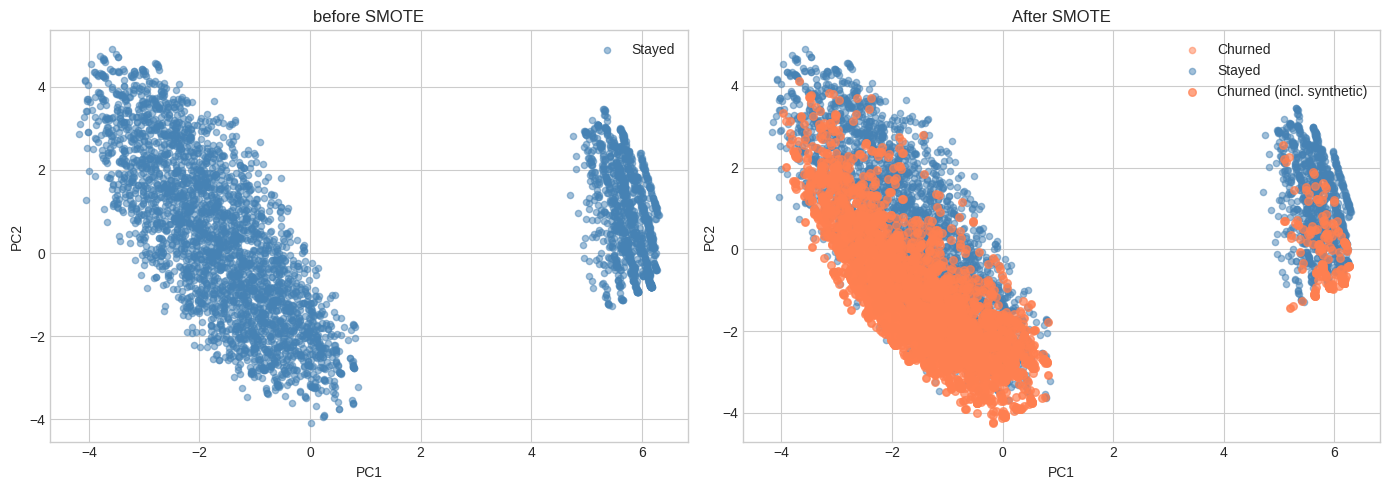

In [ ]:
"""
Visualizing how SMOTE works

"""
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
x_train_2d = pca.fit_transform(x_train_scaled)
x_train_smote_2d = pca.transform(x_train_smote)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#before smote
axes[0].scatter(x_train_2d[y_train==0, 0],
                x_train_2d[y_train==0, 1],
                c='steelblue', label='Stayed', alpha=0.5, s=20)
axes[1].scatter(x_train_2d[y_train==1, 0],
                x_train_2d[y_train==1, 1],
                c='coral', label='Churned', alpha=0.5, s=20)
axes[0].set_title("before SMOTE")
axes[0].legend()
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# After SMOTE
axes[1].scatter(x_train_smote_2d[y_train_smote==0, 0], x_train_smote_2d[y_train_smote==0, 1],
                c='steelblue', label='Stayed', alpha=0.5, s=20)
axes[1].scatter(x_train_smote_2d[y_train_smote==1, 0], x_train_smote_2d[y_train_smote==1, 1],
                c='coral', label='Churned (incl. synthetic)', alpha=0.7, s=30)
axes[1].set_title('After SMOTE')
axes[1].legend()
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

plt.tight_layout()
plt.show()

In [ ]:
#Training on SMOTE Data
model_smote = LogisticRegression(max_iter=1000, random_state=42)
model_smote.fit(x_train_smote, y_train_smote)

y_pred_smote = model_smote.predict(x_test_scaled)
y_prob_smote = model_smote.predict_proba(x_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_smote, target_names=['Stayed', 'Churned']))

              precision    recall  f1-score   support

      Stayed       0.91      0.72      0.80      1035
     Churned       0.50      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



SMOTE + Tomek Links

In [ ]:
smote_tomek = SMOTETomek(random_state=42)
x_train_st, y_train_st = smote_tomek.fit_resample(x_train_scaled, y_train)

print(f"  Before: {len(y_train)} samples")
print(f"  After:  {len(y_train_st)} samples")
print(f"\n  Class distribution after:")
print(f"    Class 0: {(y_train_st == 0).sum()}")
print(f"    Class 1: {(y_train_st == 1).sum()}")

  Before: 5634 samples
  After:  7864 samples

  Class distribution after:
    Class 0: 3932
    Class 1: 3932


In [ ]:
# Train on SMOTE+Tomek data
model_st = LogisticRegression(max_iter=1000, random_state=42)
model_st.fit(x_train_st, y_train_st)

y_pred_st = model_st.predict(x_test_scaled)
y_prob_st = model_st.predict_proba(x_test_scaled)[:, 1]

print("Strategy 6: SMOTE + Tomek Links")
print("="*50)
print(classification_report(y_test, y_pred_st, target_names=['Stayed', 'Churned']))

Strategy 6: SMOTE + Tomek Links
              precision    recall  f1-score   support

      Stayed       0.91      0.71      0.80      1035
     Churned       0.50      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.70      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [ ]:
results.append(evaluate_model('6. SMOTE+Tomek', y_test, y_pred_st, y_prob_st))

Threshold Tuning

In [ ]:
#Default threshold = 0.5
y_pred_t50 = (y_prob_baseline >= 0.5).astype(int)
print(f" Precision: {precision_score(y_test, y_pred_t50):.1%}")
print(f" Recall: {recall_score(y_test, y_pred_t50):.1%}")
print(f" F1 score: {f1_score(y_test, y_pred_t50):.1%}")

y_pred_t30 = (y_prob_baseline >= 0.3).astype(int)
print(f"\nPrecisionL: {precision_score(y_test, y_pred_t30):.1%}")
print(f"Recall: {recall_score(y_test, y_pred_t30):.1%}")
print(f"F1 score: {f1_score(y_test, y_pred_t30):.1%}")

y_pred_t20 = (y_prob_baseline >= 0.2).astype(int)
print(f"\nPrecison: {precision_score(y_test, y_pred_t20):.1%}")
print(f"Recall: {recall_score(y_test, y_pred_t20):.1%}")
print(f"F1 score: {f1_score(y_test, y_pred_t20):.1%}")

 Precision: 65.8%
 Recall: 56.7%
 F1 score: 60.9%

PrecisionL: 51.9%
Recall: 75.4%
F1 score: 61.5%

Precison: 46.7%
Recall: 85.6%
F1 score: 60.4%


In [ ]:
#FInding the optimal threshold
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_prob_baseline)

#Calculating f1 for each threshold
f1_scores = 2 * (precision_curve[:-1] * recall_curve[:-1]) / (precision_curve[:-1] + recall_curve[:-1] + 1e-10)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

print(f"Best threshold: {best_threshold:.2f}")
print(f"F! at optimal: {f1_scores[best_threshold_idx]:.3f}")

Best threshold: 0.28
F! at optimal: 0.622


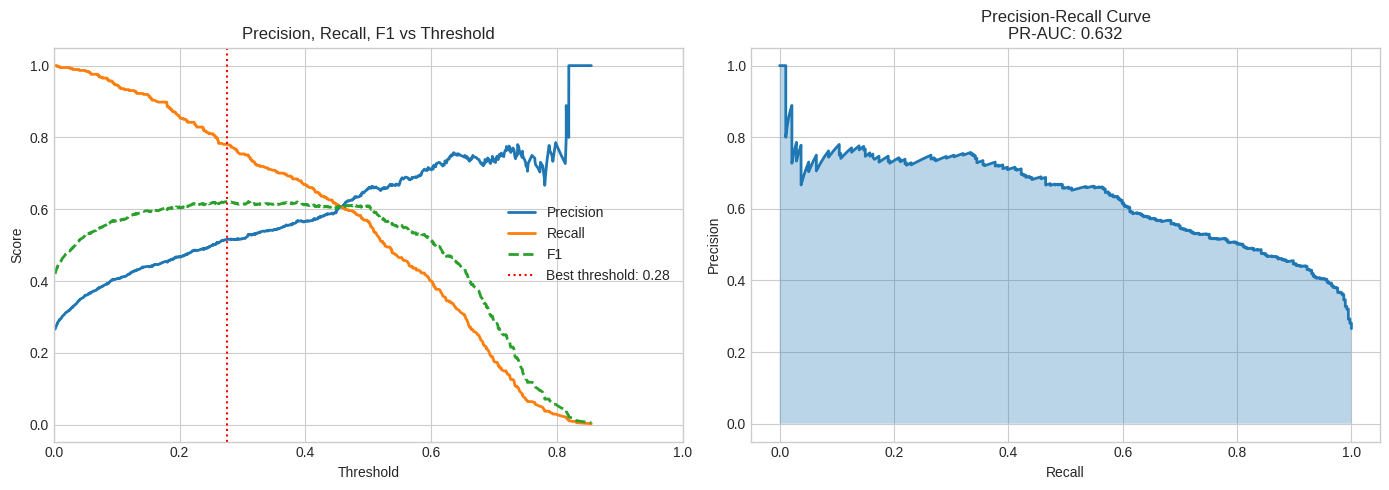

In [ ]:
#%%
# Visualize threshold tuning
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Precision-Recall vs Threshold
axes[0].plot(thresholds, precision_curve[:-1], label='Precision', linewidth=2)
axes[0].plot(thresholds, recall_curve[:-1], label='Recall', linewidth=2)
axes[0].plot(thresholds, f1_scores, label='F1', linewidth=2, linestyle='--')
axes[0].axvline(x=best_threshold, color='red', linestyle=':', label=f'Best threshold: {best_threshold:.2f}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Precision, Recall, F1 vs Threshold')
axes[0].legend()
axes[0].set_xlim(0, 1)

# Precision-Recall Curve
axes[1].plot(recall_curve, precision_curve, linewidth=2)
axes[1].fill_between(recall_curve, precision_curve, alpha=0.3)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title(f'Precision-Recall Curve\nPR-AUC: {average_precision_score(y_test, y_prob_baseline):.3f}')

plt.tight_layout()
plt.show()